In [22]:
import os

import gym
#import roboschool
import pybullet_envs
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from IPython.display import clear_output, display

from stable_baselines.a2c.utils import ortho_init
from stable_baselines.common.policies import MlpPolicy, ActorCriticPolicy, LstmPolicy # register_policy
from stable_baselines.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines.common import set_global_seeds
from stable_baselines import PPO2, GAIL
from stable_baselines.bench import Monitor
from stable_baselines.results_plotter import load_results, ts2xy
from stable_baselines.gail import generate_expert_traj, ExpertDataset

In [23]:
# env_id = "RoboschoolHumanoid-v1"
env_id = "HumanoidBulletEnv-v0"
expert_folder = "tmp/gym/humanoid/behaviour_cloning/"
expert_path = expert_folder + "expert_model.pkl"
save_path = expert_folder + "expert_model_traj.npz" # for expert trajectory
save_path_2 = expert_folder + "expert_model_samp.npz" # for expert obs random sampling

# Behaviour Cloning
- Note: Behaviour cloning in a simple supervized manner works fine with discrete control. For a continuous control task, this will not work well due to the sensitivity in the task. In a humanoid-walking situation, a slight mismatch of the expert signal and the pretrained signal can cause the agent to go away from the optimal trajectories which the pretrained agent may not encounter before. Thus, a sampling of the full input range from the expert network is required to completely "copy" the network information over to the new network.

# Trajectory Extraction 

#### Extract Samples - Expert Trajectory only

In [ ]:
if os.path.exists(save_path) is False:
    env = DummyVecEnv([lambda: gym.make(env_id)])
    model = PPO2.load(expert_path, env=env)
    generate_expert_traj(model, save_path=save_path, env=env, n_episodes=1000)
else:
    print('trajectory already exists. Extraction will not be performed')

In [5]:
dataset = ExpertDataset(expert_path=save_path, batch_size=512, train_fraction=0.9)

actions (785732, 17)
obs (785732, 44)
rewards (785732, 1)
episode_returns (1000,)
episode_starts (785732,)
Total trajectories: -1
Total transitions: 785732
Average returns: 1440.137522740841
Std for returns: 668.7370936679957


In [5]:
# # sample input & output
# dataset.init_dataloader(1)
# dataset.get_next_batch()

#### Extract Samples - Full input Range

In [6]:
if os.path.exists(save_path_2) is False:
    # obtain empirical observation limit
    env = DummyVecEnv([lambda: gym.make(env_id)])
    model = PPO2.load(expert_path, env=env)

    obs = env.reset()
    obs_shape = env.observation_space.shape
    act_shape = env.action_space.shape

    obs_max = np.zeros(obs_shape)
    obs_min = np.zeros(obs_shape)
    for i in range(10000):
        obs, _, _, _ = env.step([env.action_space.sample()]) # add [] to match with vectorized environment
        obs_max = np.maximum(obs, obs_max)
        obs_min = np.minimum(obs, obs_min)
        
    # Generate Sampling Data
    data_num = 1000000
    obs_data = np.zeros([data_num, obs_shape[0]])
    act_data = np.zeros([data_num, act_shape[0]])

    for i in range(data_num):
        obs_tmp = np.random.uniform(obs_min,obs_max)
        obs_data[i,:] = obs_tmp
        act_data[i,:],_ = model.predict(obs_tmp)

    numpy_dict = {
            'actions': act_data,
            'obs': obs_data,
            'rewards': np.zeros([data_num,1]), # dummy data
            'episode_returns': np.zeros(1000), # dummy data
            'episode_starts': np.zeros(data_num)} # dummy data

    if save_path_2 is not None:
        np.savez(save_path_2, **numpy_dict)        
else:
    print('sample file already exists. Extraction will not be performed')

sample file already exists. Extraction will not be performed


In [7]:
dataset_2 = ExpertDataset(expert_path=save_path_2, batch_size=512, train_fraction=0.9)

actions (1000000, 17)
obs (1000000, 44)
rewards (1000000, 1)
episode_returns (1000,)
episode_starts (1000000,)
Total trajectories: -1
Total transitions: 1000000
Average returns: 0.0
Std for returns: 0.0


# Pretraining

In [24]:
###### env_id = "RoboschoolHumanoid-v1"
env = gym.make(env_id)
env = DummyVecEnv([lambda: env])

#### Pretrain using Behaviour Cloning & GAIL

In [25]:
policy_kwargs = dict(act_fun=tf.nn.relu, net_arch=[dict(vf=[256,256,256], pi=[256,256,16])])
model = GAIL(MlpPolicy, env, dataset, verbose=1, policy_kwargs=policy_kwargs)

Exception ignored in: <bound method ExpertDataset.__del__ of <stable_baselines.gail.dataset.dataset.ExpertDataset object at 0x1393a5dd8>>
Traceback (most recent call last):
  File "/Users/jiachengweng/opt/anaconda3/envs/pybullet/lib/python3.6/site-packages/stable_baselines/gail/dataset/dataset.py", line 121, in __del__
    del self.dataloader, self.train_loader, self.val_loader
AttributeError: dataloader


In [26]:
model.get_parameter_list()

[<tf.Variable 'model/pi_fc0/w:0' shape=(44, 256) dtype=float32_ref>,
 <tf.Variable 'model/pi_fc0/b:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'model/vf_fc0/w:0' shape=(44, 256) dtype=float32_ref>,
 <tf.Variable 'model/vf_fc0/b:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'model/pi_fc1/w:0' shape=(256, 256) dtype=float32_ref>,
 <tf.Variable 'model/pi_fc1/b:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'model/vf_fc1/w:0' shape=(256, 256) dtype=float32_ref>,
 <tf.Variable 'model/vf_fc1/b:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'model/pi_fc2/w:0' shape=(256, 16) dtype=float32_ref>,
 <tf.Variable 'model/pi_fc2/b:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'model/vf_fc2/w:0' shape=(256, 256) dtype=float32_ref>,
 <tf.Variable 'model/vf_fc2/b:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'model/vf/w:0' shape=(256, 1) dtype=float32_ref>,
 <tf.Variable 'model/vf/b:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'model/pi/w:0' shape=(16, 17) dtype=float32_ref>,


In [11]:
model.pretrain(dataset) #behaviour cloning

Pretraining with Behavior Cloning...
==== Training progress 10.00% ====
Epoch 1
Training loss: 0.312073, Validation loss: 0.248623

==== Training progress 20.00% ====
Epoch 2
Training loss: 0.233668, Validation loss: 0.225273

==== Training progress 30.00% ====
Epoch 3
Training loss: 0.221103, Validation loss: 0.217588

==== Training progress 40.00% ====
Epoch 4
Training loss: 0.215384, Validation loss: 0.213499

==== Training progress 50.00% ====
Epoch 5
Training loss: 0.212197, Validation loss: 0.210729

==== Training progress 60.00% ====
Epoch 6
Training loss: 0.209397, Validation loss: 0.208150

==== Training progress 70.00% ====
Epoch 7
Training loss: 0.207114, Validation loss: 0.206547

==== Training progress 80.00% ====
Epoch 8
Training loss: 0.205829, Validation loss: 0.205462

==== Training progress 90.00% ====
Epoch 9
Training loss: 0.204903, Validation loss: 0.204796

==== Training progress 100.00% ====
Epoch 10
Training loss: 0.204142, Validation loss: 0.203941

Pretraining

In [12]:
model.learn(total_timesteps=100000)

********** Iteration 0 ************
Optimizing Policy...
sampling
done in 2.267 seconds
computegrad
done in 0.232 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       10.6          0
         1       2.61    0.00795
         2       11.8      0.127
         3       1.02      0.146
         4       12.7      0.198
         5      0.859      0.244
         6       10.3      0.278
         7       0.88      0.375
         8       6.82        0.4
         9       1.27      0.607
        10       10.3      0.654
done in 0.471 seconds
Expected: 0.109 Actual: 0.109
Stepsize OK!
vf
done in 0.196 seconds
sampling
done in 2.175 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       14.3          0
         1       3.08    0.00949
         2       15.2      0.123
         3       1.12      0.148
         4       13.8      0.209
         5      0.931      0.256
         6       9.71      0.285
         7      0.7

********** Iteration 3 ************
Optimizing Policy...
sampling
done in 2.182 seconds
computegrad
done in 0.028 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       17.3          0
         1       2.96    0.00967
         2       29.2      0.081
         3       1.63      0.148
         4       4.45      0.157
         5       2.58       0.25
         6       1.01      0.257
         7       12.6      0.343
         8      0.862      0.397
         9       7.28      0.424
        10       1.51       0.57
done in 0.118 seconds
Expected: 0.111 Actual: 0.113
Stepsize OK!
vf
done in 0.129 seconds
sampling
done in 2.177 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0         19          0
         1        3.4     0.0101
         2       30.6     0.0894
         3       1.29      0.154
         4       7.41      0.167
         5       1.68      0.259
         6       1.17      0.265
         7       12

********** Iteration 6 ************
Optimizing Policy...
sampling
done in 2.182 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       18.4          0
         1       3.28    0.00972
         2       22.7     0.0413
         3       2.48      0.155
         4       2.02      0.161
         5       15.2       0.24
         6       1.06      0.281
         7       5.24      0.296
         8       6.74      0.487
         9       1.27      0.511
        10       20.3      0.677
done in 0.120 seconds
Expected: 0.120 Actual: 0.115
Stepsize OK!
vf
done in 0.130 seconds
sampling
done in 2.179 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0         14          0
         1       2.68    0.00794
         2       24.6     0.0584
         3        1.6      0.136
         4          3      0.143
         5        7.4      0.235
         6       1.06      0.254
         7       9.

********** Iteration 9 ************
Optimizing Policy...
sampling
done in 2.247 seconds
computegrad
done in 0.028 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       9.51          0
         1       3.66    0.00826
         2       27.7     0.0836
         3       2.26      0.138
         4       2.42      0.143
         5       5.73      0.229
         6       1.17      0.244
         7       13.6       0.28
         8       2.28      0.399
         9       1.38      0.409
        10       14.9      0.584
done in 0.121 seconds
Expected: 0.111 Actual: 0.102
Stepsize OK!
vf
done in 0.129 seconds
sampling
done in 2.205 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       17.4          0
         1       3.86    0.00904
         2         24     0.0444
         3       2.58      0.142
         4       1.78      0.148
         5       20.6      0.225
         6       1.39      0.284
         7       2.

********** Iteration 12 ************
Optimizing Policy...
sampling
done in 2.180 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0         23          0
         1        3.8     0.0106
         2       20.5     0.0345
         3       4.96      0.127
         4       1.83      0.136
         5       17.7      0.183
         6        1.8      0.249
         7       1.84      0.256
         8       13.5      0.327
         9       1.34      0.379
        10       4.88      0.396
done in 0.118 seconds
Expected: 0.104 Actual: 0.100
Stepsize OK!
vf
done in 0.137 seconds
sampling
done in 2.170 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       12.4          0
         1        3.7    0.00867
         2       23.2      0.043
         3          4      0.132
         4       1.73      0.139
         5         20        0.2
         6       1.67      0.273
         7       1

********** Iteration 15 ************
Optimizing Policy...
sampling
done in 2.179 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       17.7          0
         1       4.06    0.00937
         2       20.8     0.0329
         3        4.8      0.129
         4       2.24      0.136
         5         16      0.176
         6       1.39      0.232
         7       5.29      0.244
         8       10.1      0.324
         9       1.26      0.353
        10       11.9      0.393
done in 0.118 seconds
Expected: 0.103 Actual: 0.097
Stepsize OK!
vf
done in 0.137 seconds
sampling
done in 2.181 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       18.6          0
         1       3.95    0.00953
         2       21.3     0.0352
         3       4.92      0.126
         4       2.29      0.135
         5       17.3      0.176
         6       1.33      0.243
         7        

********** Iteration 18 ************
Optimizing Policy...
sampling
done in 2.183 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0         14          0
         1       3.24    0.00763
         2       24.9     0.0404
         3       3.05      0.116
         4       1.91      0.122
         5         15      0.162
         6       1.71      0.209
         7       2.28      0.216
         8       15.6      0.286
         9        1.3       0.34
        10       4.03      0.353
done in 0.120 seconds
Expected: 0.093 Actual: 0.090
Stepsize OK!
vf
done in 0.141 seconds
sampling
done in 2.241 seconds
computegrad
done in 0.026 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       9.82          0
         1       3.89    0.00798
         2       30.6     0.0619
         3        3.1      0.131
         4       2.19      0.137
         5       17.7       0.19
         6       1.64      0.243
         7        

********** Iteration 21 ************
Optimizing Policy...
sampling
done in 2.196 seconds
computegrad
done in 0.028 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       23.6          0
         1       3.67    0.00966
         2       17.1     0.0252
         3       12.1      0.135
         4       1.19      0.149
         5         10      0.164
         6       6.64      0.245
         7       1.06      0.259
         8       13.1      0.295
         9       3.46      0.413
        10       1.34      0.424
done in 0.119 seconds
Expected: 0.105 Actual: 0.103
Stepsize OK!
vf
done in 0.141 seconds
sampling
done in 2.206 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       16.6          0
         1       4.11     0.0085
         2       34.7     0.0443
         3       11.5      0.159
         4       1.75      0.172
         5       13.8      0.191
         6       5.75      0.285
         7       1

********** Iteration 24 ************
Optimizing Policy...
sampling
done in 2.178 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       12.6          0
         1       4.07    0.00866
         2       33.1     0.0467
         3       5.29      0.131
         4        1.7      0.139
         5       14.2      0.161
         6        2.3      0.242
         7       1.49      0.249
         8       15.3      0.316
         9       1.73      0.375
        10       3.88      0.388
done in 0.117 seconds
Expected: 0.101 Actual: 0.103
Stepsize OK!
vf
done in 0.140 seconds
sampling
done in 2.187 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       11.3          0
         1       3.67    0.00712
         2       20.6      0.032
         3       5.44      0.132
         4       1.66      0.139
         5       9.71      0.154
         6        3.5      0.245
         7       1

********** Iteration 27 ************
Optimizing Policy...
sampling
done in 2.193 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       14.5          0
         1       3.58    0.00771
         2       27.5     0.0372
         3       6.59      0.133
         4       1.37      0.141
         5       9.36      0.153
         6       8.07      0.239
         7        1.2      0.255
         8       10.3      0.282
         9       2.96      0.384
        10       1.67      0.394
done in 0.118 seconds
Expected: 0.100 Actual: 0.097
Stepsize OK!
vf
done in 0.142 seconds
sampling
done in 2.188 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       15.9          0
         1       3.78    0.00808
         2         21     0.0258
         3       5.59      0.135
         4       1.36      0.143
         5         15      0.166
         6       2.13      0.236
         7       1

********** Iteration 30 ************
Optimizing Policy...
sampling
done in 2.182 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       7.75          0
         1       4.55    0.00741
         2       33.8     0.0544
         3       4.13      0.141
         4        1.8      0.146
         5       16.5      0.172
         6       4.27      0.256
         7       1.24      0.265
         8       13.3      0.293
         9       3.72      0.387
        10       1.75        0.4
done in 0.118 seconds
Expected: 0.101 Actual: 0.100
Stepsize OK!
vf
done in 0.142 seconds
sampling
done in 2.214 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       10.2          0
         1       3.69    0.00732
         2       38.7     0.0616
         3       4.52      0.136
         4        1.6      0.142
         5       18.6      0.167
         6       3.51      0.243
         7       1

********** Iteration 33 ************
Optimizing Policy...
sampling
done in 2.174 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       14.6          0
         1       4.05    0.00747
         2       22.3     0.0285
         3         13      0.121
         4       1.65      0.136
         5        6.8      0.145
         6        5.5      0.242
         7       1.42      0.254
         8       16.4      0.294
         9       3.44      0.414
        10       2.32      0.427
done in 0.118 seconds
Expected: 0.104 Actual: 0.103
Stepsize OK!
vf
done in 0.142 seconds
sampling
done in 2.173 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       11.3          0
         1       3.87    0.00715
         2       28.3     0.0355
         3       11.4      0.138
         4       1.65      0.151
         5       7.51      0.161
         6       14.2      0.249
         7       1

********** Iteration 36 ************
Optimizing Policy...
sampling
done in 2.207 seconds
computegrad
done in 0.028 seconds
conjugate_gradient
      iter residual norm  soln norm
         0         16          0
         1        4.2    0.00746
         2       24.9     0.0302
         3       12.6      0.129
         4       1.52      0.142
         5       8.36      0.153
         6       7.11      0.249
         7       1.21      0.262
         8       5.51      0.273
         9       8.46      0.388
        10       1.39      0.412
done in 0.120 seconds
Expected: 0.104 Actual: 0.100
Stepsize OK!
vf
done in 0.145 seconds
sampling
done in 2.180 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       13.7          0
         1       3.58    0.00719
         2       21.6     0.0281
         3         10      0.124
         4       1.35      0.134
         5       4.68      0.141
         6       10.4       0.23
         7      0.

********** Iteration 39 ************
Optimizing Policy...
sampling
done in 2.176 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0         13          0
         1       3.98    0.00779
         2       32.1     0.0413
         3       6.81      0.119
         4       2.18      0.127
         5       18.4      0.163
         6       3.94      0.228
         7       2.27      0.237
         8       16.3      0.304
         9       1.92       0.36
        10       5.64      0.374
done in 0.119 seconds
Expected: 0.100 Actual: 0.102
Stepsize OK!
vf
done in 0.147 seconds
sampling
done in 2.180 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       23.1          0
         1       3.27    0.00897
         2       30.4     0.0427
         3       7.09      0.133
         4       1.48      0.141
         5       8.48      0.151
         6       8.79      0.225
         7        

********** Iteration 42 ************
Optimizing Policy...
sampling
done in 2.380 seconds
computegrad
done in 0.028 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       12.6          0
         1       3.56    0.00726
         2       24.7     0.0293
         3         10      0.122
         4       1.73      0.133
         5       5.88      0.141
         6       13.7      0.223
         7       1.41       0.25
         8       7.33      0.265
         9       5.46      0.381
        10       1.57      0.395
done in 0.123 seconds
Expected: 0.099 Actual: 0.099
Stepsize OK!
vf
done in 0.150 seconds
sampling
done in 2.381 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       14.1          0
         1       5.02     0.0078
         2       45.5     0.0595
         3       8.07      0.139
         4       2.49      0.148
         5       12.5      0.162
         6       9.06       0.24
         7       1

********** Iteration 45 ************
Optimizing Policy...
sampling
done in 2.333 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       13.1          0
         1       4.11    0.00756
         2       27.3     0.0389
         3       7.72      0.103
         4       1.87      0.111
         5       12.7       0.13
         6       5.52      0.212
         7       1.74      0.223
         8       10.6      0.244
         9       4.46      0.335
        10       1.81      0.348
done in 0.118 seconds
Expected: 0.096 Actual: 0.097
Stepsize OK!
vf
done in 0.144 seconds
sampling
done in 2.221 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       18.7          0
         1       3.88     0.0089
         2       17.7     0.0244
         3       13.1      0.139
         4          2      0.153
         5       11.7       0.17
         6       11.2      0.238
         7       1

********** Iteration 48 ************
Optimizing Policy...
sampling
done in 2.179 seconds
computegrad
done in 0.028 seconds
conjugate_gradient
      iter residual norm  soln norm
         0         20          0
         1       3.15    0.00755
         2       14.1     0.0199
         3       30.1      0.096
         4       2.37      0.142
         5       3.25      0.148
         6       19.9      0.204
         7       2.51      0.256
         8       3.05      0.264
         9       7.75      0.363
        10       1.69      0.386
done in 0.119 seconds
Expected: 0.099 Actual: 0.103
Stepsize OK!
vf
done in 0.142 seconds
sampling
done in 2.181 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       11.5          0
         1       5.02    0.00686
         2       20.2     0.0263
         3       16.4       0.12
         4       2.21      0.136
         5       6.47      0.145
         6       17.9      0.227
         7        

********** Iteration 51 ************
Optimizing Policy...
sampling
done in 2.187 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       17.8          0
         1       3.96    0.00913
         2       15.5     0.0223
         3       17.4      0.103
         4       2.17      0.123
         5       6.44      0.133
         6       6.54      0.213
         7       1.61      0.224
         8       7.87      0.241
         9       5.89      0.344
        10       2.07      0.361
done in 0.119 seconds
Expected: 0.099 Actual: 0.098
Stepsize OK!
vf
done in 0.144 seconds
sampling
done in 2.187 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       16.5          0
         1       3.97    0.00918
         2       29.1     0.0515
         3       7.16      0.112
         4       1.97      0.121
         5       12.6       0.14
         6       7.38      0.229
         7       1

********** Iteration 54 ************
Optimizing Policy...
sampling
done in 2.176 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       11.4          0
         1       4.71    0.00829
         2       26.5     0.0372
         3       12.1      0.131
         4       2.42      0.147
         5       14.8      0.168
         6       5.88      0.266
         7          2      0.277
         8       10.6      0.293
         9       7.91      0.449
        10       2.23      0.469
done in 0.118 seconds
Expected: 0.112 Actual: 0.110
Stepsize OK!
vf
done in 0.144 seconds
sampling
done in 2.180 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       17.2          0
         1       4.63    0.00949
         2       28.9       0.04
         3         12      0.125
         4       1.97      0.137
         5       5.93      0.145
         6       9.94      0.251
         7        

********** Iteration 57 ************
Optimizing Policy...
sampling
done in 2.190 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       19.4          0
         1       4.18    0.00786
         2       13.6     0.0201
         3       12.1      0.106
         4       2.26      0.118
         5       8.06      0.129
         6       10.7      0.234
         7       1.83      0.257
         8         14      0.291
         9       4.05      0.399
        10       2.45      0.413
done in 0.119 seconds
Expected: 0.104 Actual: 0.101
Stepsize OK!
vf
done in 0.145 seconds
sampling
done in 2.168 seconds
computegrad
done in 0.026 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       13.4          0
         1        4.6    0.00737
         2       21.7     0.0286
         3       17.3      0.109
         4       2.32      0.128
         5        6.6      0.137
         6       15.2      0.215
         7       2

********** Iteration 60 ************
Optimizing Policy...
sampling
done in 2.169 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       17.6          0
         1       4.43    0.00787
         2       17.4     0.0213
         3       16.9      0.111
         4       2.53      0.134
         5       14.5      0.154
         6       9.26      0.256
         7       2.11      0.271
         8       14.3      0.302
         9       3.99      0.427
        10       2.51       0.44
done in 0.119 seconds
Expected: 0.110 Actual: 0.114
Stepsize OK!
vf
done in 0.144 seconds
sampling
done in 2.196 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0         16          0
         1       5.04    0.00836
         2       33.9     0.0418
         3       12.6       0.11
         4        2.1      0.122
         5       11.5      0.139
         6        5.9      0.229
         7        

********** Iteration 63 ************
Optimizing Policy...
sampling
done in 2.195 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       12.1          0
         1       5.29    0.00709
         2       26.4     0.0286
         3       15.6      0.134
         4       2.16      0.149
         5       9.18       0.16
         6       13.7      0.245
         7       1.93      0.271
         8         10      0.291
         9        4.9      0.438
        10       1.97      0.453
done in 0.118 seconds
Expected: 0.112 Actual: 0.120
Stepsize OK!
vf
done in 0.141 seconds
sampling
done in 2.180 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       11.2          0
         1       5.85    0.00765
         2       40.2     0.0501
         3       10.4      0.121
         4       2.25       0.13
         5       13.4      0.145
         6       9.97      0.224
         7       1

********** Iteration 66 ************
Optimizing Policy...
sampling
done in 2.176 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       11.6          0
         1       4.85      0.007
         2       26.4     0.0302
         3       14.7       0.12
         4       2.15      0.134
         5       16.2      0.158
         6       7.91      0.241
         7        2.2      0.254
         8       9.32      0.272
         9       5.82      0.385
        10       2.68      0.401
done in 0.118 seconds
Expected: 0.105 Actual: 0.108
Stepsize OK!
vf
done in 0.146 seconds
sampling
done in 2.177 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       11.2          0
         1       5.36     0.0071
         2       37.3     0.0421
         3       6.23      0.134
         4       2.79      0.141
         5       12.1      0.154
         6       6.12      0.228
         7        

********** Iteration 69 ************
Optimizing Policy...
sampling
done in 2.186 seconds
computegrad
done in 0.028 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       8.77          0
         1       5.36    0.00855
         2       40.4     0.0615
         3       6.84      0.126
         4        2.7      0.134
         5       12.6      0.151
         6       9.77      0.236
         7       1.99      0.252
         8       11.3      0.274
         9       5.61      0.414
        10       2.26      0.429
done in 0.119 seconds
Expected: 0.108 Actual: 0.108
Stepsize OK!
vf
done in 0.145 seconds
sampling
done in 2.193 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       14.4          0
         1       5.68    0.00807
         2       22.7     0.0255
         3       11.2      0.103
         4       3.71      0.115
         5       17.2      0.138
         6       6.61      0.209
         7       2

********** Iteration 72 ************
Optimizing Policy...
sampling
done in 2.197 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       12.5          0
         1       4.97    0.00818
         2       34.5     0.0406
         3       14.9      0.124
         4       2.73      0.139
         5       10.4      0.155
         6       4.75      0.217
         7       2.49      0.226
         8       13.8      0.253
         9       4.79      0.349
        10       3.53      0.364
done in 0.118 seconds
Expected: 0.104 Actual: 0.110
Stepsize OK!
vf
done in 0.143 seconds
sampling
done in 2.182 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       13.3          0
         1       4.12    0.00756
         2       37.3     0.0494
         3       9.95      0.134
         4       2.57      0.144
         5       14.2       0.16
         6       9.24      0.259
         7        

********** Iteration 75 ************
Optimizing Policy...
sampling
done in 2.178 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       15.1          0
         1       5.81    0.00892
         2       45.2     0.0534
         3       14.2      0.142
         4       3.08      0.156
         5       13.2      0.173
         6       5.81      0.248
         7       2.83      0.257
         8       21.6      0.304
         9       3.37      0.384
        10       3.36      0.396
done in 0.119 seconds
Expected: 0.114 Actual: 0.116
Stepsize OK!
vf
done in 0.145 seconds
sampling
done in 2.453 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       15.5          0
         1       5.89    0.00811
         2       41.6     0.0507
         3       10.6      0.125
         4       2.48      0.134
         5         17      0.163
         6       3.42      0.231
         7       4

********** Iteration 78 ************
Optimizing Policy...
sampling
done in 2.194 seconds
computegrad
done in 0.028 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       14.3          0
         1       4.61    0.00688
         2       22.9     0.0251
         3       15.9      0.105
         4       2.68      0.121
         5       10.4      0.134
         6       15.4        0.2
         7       2.02      0.227
         8       13.1       0.25
         9       4.81      0.342
        10       3.63      0.357
done in 0.118 seconds
Expected: 0.101 Actual: 0.101
Stepsize OK!
vf
done in 0.145 seconds
sampling
done in 2.173 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       14.7          0
         1       4.62    0.00749
         2       33.9      0.044
         3       13.2      0.109
         4       2.27      0.121
         5       9.79      0.133
         6       15.6      0.222
         7       2

********** Iteration 81 ************
Optimizing Policy...
sampling
done in 2.191 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       18.4          0
         1       5.66    0.00859
         2       32.6     0.0349
         3       16.7      0.103
         4       3.17      0.118
         5       12.8      0.133
         6       9.68      0.193
         7       2.58      0.206
         8       9.65      0.221
         9       9.74      0.321
        10       2.33      0.343
done in 0.119 seconds
Expected: 0.105 Actual: 0.104
Stepsize OK!
vf
done in 0.145 seconds
sampling
done in 2.187 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       13.9          0
         1       4.99    0.00671
         2       20.9     0.0219
         3       9.13      0.114
         4       2.95      0.125
         5       16.9      0.146
         6       6.35        0.2
         7       3

********** Iteration 84 ************
Optimizing Policy...
sampling
done in 2.255 seconds
computegrad
done in 0.028 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       21.2          0
         1       4.82    0.00781
         2       22.1     0.0252
         3       32.7     0.0905
         4       3.29      0.127
         5       4.79      0.133
         6       28.8      0.187
         7       4.28      0.248
         8       4.71      0.261
         9       12.4      0.363
        10       2.71      0.391
done in 0.124 seconds
Expected: 0.108 Actual: 0.109
Stepsize OK!
vf
done in 0.143 seconds
sampling
done in 2.194 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       26.3          0
         1       4.78     0.0088
         2       18.4     0.0218
         3       21.1      0.102
         4       2.46      0.122
         5       10.8      0.134
         6       17.4      0.193
         7       2

********** Iteration 87 ************
Optimizing Policy...
sampling
done in 2.189 seconds
computegrad
done in 0.028 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       8.87          0
         1       7.17    0.00804
         2       40.5     0.0578
         3       11.9      0.113
         4       3.44      0.124
         5       13.5      0.137
         6       18.4      0.196
         7       3.67      0.222
         8       9.57      0.238
         9       8.83       0.33
        10        3.4      0.348
done in 0.120 seconds
Expected: 0.104 Actual: 0.110
Stepsize OK!
vf
done in 0.145 seconds
sampling
done in 2.187 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       15.9          0
         1       5.73      0.008
         2       28.1     0.0333
         3       23.4      0.105
         4       2.69      0.122
         5       4.04      0.127
         6       17.9      0.186
         7       1

********** Iteration 90 ************
Optimizing Policy...
sampling
done in 2.190 seconds
computegrad
done in 0.028 seconds
conjugate_gradient
      iter residual norm  soln norm
         0         12          0
         1       6.98     0.0079
         2       36.9     0.0354
         3       22.3      0.106
         4       4.22      0.126
         5       6.97      0.134
         6       20.8      0.175
         7        3.2      0.206
         8       8.78      0.222
         9       5.56      0.286
        10        3.2      0.299
done in 0.118 seconds
Expected: 0.101 Actual: 0.105
Stepsize OK!
vf
done in 0.144 seconds
sampling
done in 2.193 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0         24          0
         1       6.24    0.00789
         2         17     0.0167
         3       23.6      0.104
         4       2.89      0.129
         5       4.78      0.134
         6       21.2      0.168
         7       3

********** Iteration 93 ************
Optimizing Policy...
sampling
done in 2.203 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       17.4          0
         1       6.39    0.00763
         2       16.5     0.0178
         3       27.4      0.107
         4       5.01      0.134
         5        7.4      0.143
         6       15.7      0.181
         7       3.31      0.211
         8         11       0.23
         9       8.02      0.332
        10       2.37      0.347
done in 0.118 seconds
Expected: 0.106 Actual: 0.102
Stepsize OK!
vf
done in 0.147 seconds
sampling
done in 2.196 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       27.1          0
         1        6.7    0.00746
         2       9.34     0.0134
         3       27.5     0.0763
         4        4.8      0.112
         5       10.8      0.126
         6       16.8      0.169
         7       3

********** Iteration 96 ************
Optimizing Policy...
sampling
done in 2.185 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       17.5          0
         1       5.42    0.00865
         2         31     0.0413
         3       16.5      0.108
         4       3.87      0.121
         5       9.68      0.132
         6       12.1      0.183
         7       3.26        0.2
         8       11.5      0.214
         9       9.12      0.297
        10       2.61      0.314
done in 0.119 seconds
Expected: 0.102 Actual: 0.099
Stepsize OK!
vf
done in 0.147 seconds
sampling
done in 2.190 seconds
computegrad
done in 0.027 seconds
conjugate_gradient
      iter residual norm  soln norm
         0       15.4          0
         1       6.08    0.00754
         2       34.2     0.0367
         3       18.5       0.11
         4       2.76      0.125
         5       8.42      0.134
         6       27.9      0.202
         7       5

In [14]:
env_v = gym.make('RoboschoolHumanoid-v1')
obs = env_v.reset()
for i in range(500):
    actions, _states = model.predict(obs)
    obs, rewards, dones, info = env_v.step(actions)
    env_v.render()

NameError: name 'model' is not defined

In [13]:
model.save(expert_folder+"pretrained_model_GAIL")
del model

In [5]:
model = GAIL.load(expert_folder+"pretrained_model_GAIL")
GAIL_param = model.get_parameters()
del model

Loading a model without an environment, this model cannot be trained until it has a valid environment.


# Fine Tuning

In [3]:
log_dir = "tmp/gym/humanoid/behaviour_cloning/log/"
os.makedirs(log_dir, exist_ok=True)

# Set up Wrapper
from gym import RewardWrapper

class ModifyReward(RewardWrapper):
    def __init__(self, env):
        super(ModifyReward, self).__init__(env)

    def reward(self, reward):
        return reward
    
##########################################################################################
# Set up multiprocessing
def make_env(env_id, rank, seed=0):
    """
    Utility function for multiprocessed env.
    
    :param env_id: (str) the environment ID
    :param num_env: (int) the number of environment you wish to have in subprocesses 
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    """
    
    def _init():
        env = ModifyReward(gym.make(env_id))
        log_sub_dir = log_dir + '/env_{}'.format(str(rank))
        os.makedirs(log_sub_dir, exist_ok=True)
        env = Monitor(env, log_sub_dir, allow_early_resets=True)
        env.seed(seed + rank)
        return env
    set_global_seeds(seed)
    return _init

##########################################################################################
# Set up callback
best_mean_reward, n_steps = -np.inf, 0

def extract_xy(log_dir):
    """
    extract the # time steps and avg reward
    :param x: (int) # of time steps
    :param y: (float) average rewards
    """
    num_folder = 0
    x = 0
    y = []
    for folder in os.listdir(log_dir):
        if 'env' in folder:
            x_tmp, y_tmp = ts2xy(load_results(log_dir+folder), 'timesteps')
            if len(x_tmp) > 0:
                y.extend(list(y_tmp[-10:]))
                if x_tmp[-1] > x:
                    x = x_tmp[-1]
    y = sum(y)/len(y) if len(y) > 0 else -np.inf 
    return x, y

def callback(_locals, _globals):
    """
    Callback called at each step (for DQN an others) or after n steps (see ACER or PPO2)
    :param _locals: (dict)
    :param _globals: (dict)
    """
    global n_steps, best_mean_reward
    # Print stats every 2 calls
    if (n_steps + 1) % 2 == 0:
        # Evaluate policy training performance
        x, y = extract_xy(log_dir)
        if x > 0:
            mean_reward = y
            clear_output(wait=True)
            # use display(f) if you encounter performance issues
            print(x, 'timesteps')
            print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}". \
                  format(best_mean_reward, mean_reward))
            
            # New best model, you could save the agent here
            if mean_reward > best_mean_reward:
                best_mean_reward = mean_reward
                # Example for saving best model
                print("Saving new best model")
                _locals['self'].save(log_dir + 'best_model.pkl')
    n_steps += 1
    return True

In [4]:
env_id = "RoboschoolHumanoid-v1"
num_cpu = 8  # Number of processes to use
# Create the vectorized environment

env = SubprocVecEnv([make_env(env_id, i) for i in range(num_cpu)], start_method = 'fork')

/Users/jiachengweng/opt/anaconda3/envs/stable-baselines/lib/python3.6/site-packages/roboschool/gym_mujoco_xml_env.py:23: UserWarning: roboschool has been deprecated in favor of PyBullet, see https://github.com/openai/roboschool#news
  warnings.warn("roboschool has been deprecated in favor of PyBullet, see https://github.com/openai/roboschool#news")
/Users/jiachengweng/opt/anaconda3/envs/stable-baselines/lib/python3.6/site-packages/roboschool/gym_mujoco_xml_env.py:23: UserWarning: roboschool has been deprecated in favor of PyBullet, see https://github.com/openai/roboschool#news
  warnings.warn("roboschool has been deprecated in favor of PyBullet, see https://github.com/openai/roboschool#news")
/Users/jiachengweng/opt/anaconda3/envs/stable-baselines/lib/python3.6/site-packages/roboschool/gym_mujoco_xml_env.py:23: UserWarning: roboschool has been deprecated in favor of PyBullet, see https://github.com/openai/roboschool#news
  warnings.warn("roboschool has been deprecated in favor of PyBul

  File "/Users/jiachengweng/opt/anaconda3/envs/stable-baselines/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/Users/jiachengweng/opt/anaconda3/envs/stable-baselines/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/Users/jiachengweng/opt/anaconda3/envs/stable-baselines/lib/python3.6/site-packages/stable_baselines/common/vec_env/subproc_vec_env.py", line 16, in _worker
    cmd, data = remote.recv()
  File "/Users/jiachengweng/opt/anaconda3/envs/stable-baselines/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/Users/jiachengweng/opt/anaconda3/envs/stable-baselines/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/Users/jiachengweng/opt/anaconda3/envs/stable-baselines/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  Fi

In [5]:
def learning_rate(frac):
    return 1.0e-4*(np.exp(6*(frac-1)))

# modified policy network: with bottleneck
policy_kwargs = dict(act_fun=tf.nn.relu, net_arch=[dict(vf=[256,256,256], pi=[256,256,16])])

model = PPO2(MlpPolicy, env, verbose=0, policy_kwargs=policy_kwargs, 
             noptepochs=15, n_steps=512, learning_rate=learning_rate)

In [9]:
# extract parameters from GAIL for PPO2
model_paramlist = model.get_parameter_list()
model_paramname = []
for i in range(len(model_paramlist)):
    model_paramname.append(model_paramlist[i].name)

GAIL_param_extracted = {key:value for key,value in GAIL_param.items() if key in model_paramname}

In [10]:
model.load_parameters(GAIL_param_extracted, exact_match=True)

#### Step 4: Fine Tune the agent

In [6]:
model.learn(total_timesteps=40000000, callback=callback)

# saves the agent as a .pkl file
model.save(log_dir+'latest_trained_model') 

2620359 timesteps
Best mean reward: 592.02 - Last mean reward per episode: 454.67


KeyboardInterrupt: 

#### Step 5: Render the results

In [6]:
model.load_parameters(log_dir+'best_model', exact_match=True)

In [12]:
env_v = gym.make('RoboschoolHumanoid-v1')
obs = env_v.reset()
for i in range(500):
    actions, _states = model.predict(obs)
    obs, rewards, dones, info = env_v.step(actions)
    env_v.render()

/Users/jiachengweng/opt/anaconda3/envs/stable-baselines/lib/python3.6/site-packages/roboschool/gym_mujoco_xml_env.py:23: UserWarning: roboschool has been deprecated in favor of PyBullet, see https://github.com/openai/roboschool#news
  warnings.warn("roboschool has been deprecated in favor of PyBullet, see https://github.com/openai/roboschool#news")


#### Step 6: Plot the results

In [7]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve', instances=1, same_plot=False):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    :instances: (int) the number of instances to average
    """
    x, y = ts2xy(load_results(log_folder+'/env_0'), 'timesteps')

    if instances > 1:
        for i in range(1,instances):
            _, y_tmp = ts2xy(load_results(log_folder+'/env_'+str(i)), 'timesteps')
            if len(y) > len(y_tmp):
                y = y[:len(y_tmp)] + y_tmp
            else:
                y = y + y_tmp[:len(y)]
        y = y/instances
    
    y = moving_average(y, window=50) # change window value to change level of smoothness
    # Truncate x
    x = x[len(x) - len(y):]
    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    if same_plot is False:
        plt.show()

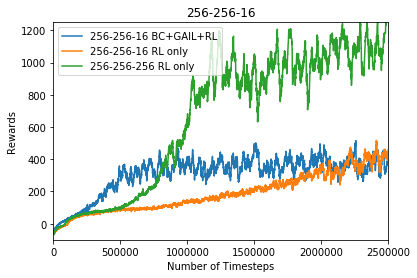

In [14]:
plot_results(expert_folder+"archive/BC+GAIL+RL 256-256-16", same_plot=True)
plot_results(expert_folder+"archive/RL 256-256-16", same_plot=True)
plot_results("tmp/gym/humanoid/archive/10-relu 256-256-256 40m step 1e-4 poly decayed lr", same_plot=True)
plt.title("256-256-16")
plt.xlim(0,2500000)
plt.ylim(-100,1250)
plt.legend(['256-256-16 BC+GAIL+RL','256-256-16 RL only','256-256-256 RL only'])